<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_d%5Dnonlinear_regression_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer DNN — Nonlinear Regression with PyTorch Lightning
Uses `LightningModule` + `Trainer` + explicit `CSVLogger` for reliable metrics.

## 0. Install

In [1]:
!pip install lightning -q
import importlib, lightning
print('Lightning version:', lightning.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 30.0 MB/s eta 0:00:00
Lightning version: 2.6.1


## 1. Imports

In [2]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
import lightning as L
from lightning.pytorch.loggers import CSVLogger

## 2. Generate Nonlinear Data  `y = sin(2πx) + noise`

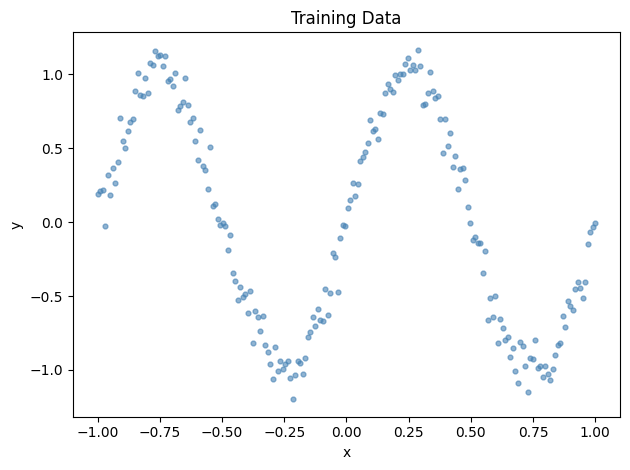

In [3]:
torch.manual_seed(42)

X = torch.linspace(-1, 1, 200).unsqueeze(1)              # shape (200, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.randn_like(X)

# DataLoader — Lightning Trainer expects a DataLoader
dataset    = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

plt.scatter(X.numpy(), y.numpy(), s=12, alpha=0.6, color='steelblue')
plt.title('Training Data'); plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout(); plt.show()

## 3. LightningModule

Three methods are all Lightning needs:

| Method | Purpose |
|---|---|
| `forward` | defines the network / inference |
| `training_step` | compute loss — Lightning auto-calls `backward` + `optimizer.step` |
| `configure_optimizers` | return optimizer (and optionally a scheduler) |

In [4]:
class RegressionNet(L.LightningModule):
    """3-layer MLP for nonlinear regression."""

    def __init__(self, input_dim: int = 1, hidden_dim: int = 64,
                 output_dim: int = 1, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()          # stores & logs all __init__ args

        # ── Architecture: 3 layers ────────────────────────────────────────
        self.net = nn.Sequential(
            nn.Linear(input_dim,  hidden_dim),   # Layer 1
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),   # Layer 2
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),   # Layer 3 → output
        )
        self.loss_fn = nn.MSELoss()

    # ── Forward ───────────────────────────────────────────────────────────
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

    # ── Training step  (backprop is automatic after returning loss) ────────
    def training_step(self, batch, batch_idx: int) -> torch.Tensor:
        x, y   = batch
        y_hat  = self(x)
        loss   = self.loss_fn(y_hat, y)

        # on_epoch=True  → accumulates & logs the epoch-mean (good for CSV)
        # on_step=False  → suppresses noisy per-step entries
        self.log('train_loss', loss,
                 on_step=False, on_epoch=True,
                 prog_bar=True, logger=True)
        return loss

    # ── Optimizer ─────────────────────────────────────────────────────────
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## 4. Trainer + CSVLogger

We attach a **`CSVLogger`** explicitly so we always know exactly where `metrics.csv` is written.

In [5]:
LOG_DIR  = 'my_logs'   # top-level folder
EXP_NAME = 'regression_run'

logger = CSVLogger(save_dir=LOG_DIR, name=EXP_NAME)

model   = RegressionNet(hidden_dim=64, lr=1e-3)

trainer = L.Trainer(
    max_epochs        = 300,
    logger            = logger,          # ← explicit CSV logger
    log_every_n_steps = 1,               # log every step (safe for small datasets)
    enable_progress_bar = True,
    accelerator       = 'auto',          # uses GPU if available, else CPU
)

trainer.fit(model, dataloader)

# Print where the CSV was saved
print('\nMetrics CSV:', logger.experiment.metrics_file_path)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net     │ Sequential │  4.4 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 4.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.



Metrics CSV: my_logs/regression_run/version_0/metrics.csv


## 5. Plot Training Loss from `metrics.csv`

Columns in metrics.csv: ['epoch', 'step', 'train_loss']
   epoch  step  train_loss
0      0     6    0.512636
1      1    13    0.469105
2      2    20    0.442505
3      3    27    0.425141
4      4    34    0.411167


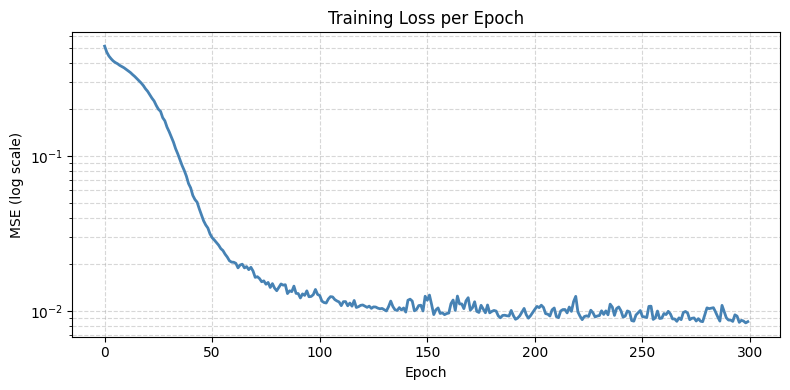

In [6]:
# Use the exact path Lightning reported
csv_path = logger.experiment.metrics_file_path

metrics = pd.read_csv(csv_path)
print('Columns in metrics.csv:', metrics.columns.tolist())
print(metrics.head())

# epoch-level loss (on_epoch=True ensures one row per epoch)
epoch_metrics = metrics.dropna(subset=['train_loss'])

plt.figure(figsize=(8, 4))
plt.plot(epoch_metrics['epoch'].values,
         epoch_metrics['train_loss'].values,
         color='steelblue', linewidth=2)
plt.yscale('log')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('MSE (log scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

## 6. Predictions vs Ground Truth

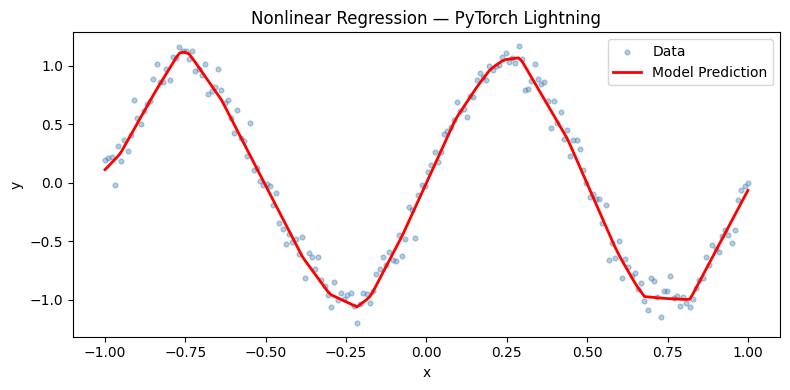

Final epoch loss: 0.008499


In [7]:
model.eval()
model.cpu()                        # ensure CPU for inference
with torch.no_grad():
    y_pred = model(X).numpy()

plt.figure(figsize=(8, 4))
plt.scatter(X.numpy(), y.numpy(), s=12, alpha=0.4,
            color='steelblue', label='Data')
plt.plot(X.numpy(), y_pred, color='red',
         linewidth=2, label='Model Prediction')
plt.title('Nonlinear Regression — PyTorch Lightning')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.tight_layout(); plt.show()

final_loss = epoch_metrics['train_loss'].iloc[-1]
print(f'Final epoch loss: {final_loss:.6f}')

## 7. Inspect Saved Checkpoints & Hyperparameters

In [8]:
# Lightning auto-saves a checkpoint in the log version folder
ckpt_files = glob.glob(os.path.join(logger.log_dir, 'checkpoints', '*.ckpt'))
print('Saved checkpoints:')
for c in ckpt_files:
    print(' ', c)

# Reload model from checkpoint
if ckpt_files:
    loaded = RegressionNet.load_from_checkpoint(ckpt_files[-1])
    print('\nLoaded hparams:', loaded.hparams)

# Hyperparameters saved by save_hyperparameters()
hparams_file = os.path.join(logger.log_dir, 'hparams.yaml')
if os.path.exists(hparams_file):
    print('\nhparams.yaml:')
    print(open(hparams_file).read())

Saved checkpoints:
  my_logs/regression_run/version_0/checkpoints/epoch=299-step=2100.ckpt

Loaded hparams: "hidden_dim": 64
"input_dim":  1
"lr":         0.001
"output_dim": 1

hparams.yaml:
input_dim: 1
hidden_dim: 64
output_dim: 1
lr: 0.001

